# langgraph-bigtool

[`langgraph-bigtool`](https://github.com/langchain-ai/langgraph-bigtool) is a Python library for creating [LangGraph](https://langchain-ai.github.io/langgraph/) agents that can access large numbers of tools. It leverages LangGraph's long-term [memory store](https://langchain-ai.github.io/langgraph/how-tos/memory/semantic-search/) to allow an agent to search for and retrieve relevant tools for a given problem.

## BigTool: Tools "On-demand"

- Has access to a single retrieval tool initially
- Dynamically searches for and retrieves only relevant tools
- Only loads what's needed for the specific task

![](https://mirror-feeling-d80.notion.site/image/attachment%3Ae0311609-3bf3-43fd-8b41-e18a7414ba8f%3Aimage.png?table=block&id=1c180852-7b17-8011-b804-e6f269ea2a48&spaceId=c2810b1e-a85a-492f-bc51-5aa2decfa5ac&width=1420&userId=&cache=v2)

### Benefits

- Reasoning load - Reduced cognitive load for the agent
- Scalability - can handle hundreds/thousands of tools

### vs Multi-agent

- **Pro**: Doesn't require putting tools into explicit groups, lower overhead (single agent)
- **Con**: If there is an underlying organization of the tools (e.g., into groups), you might be better off representing that explicitly via separate agents (each of which can have distinct system messages, which bigtool also doesn't support).

## Features

- 🧰 **Scalable access to tools**: Equip agents with hundreds or thousands of tools.
- 📝 **Storage of tool metadata**: Control storage of tool descriptions, namespaces, and other information through LangGraph's built-in [persistence layer](https://langchain-ai.github.io/langgraph/concepts/persistence/). Includes support for [in-memory](https://langchain-ai.github.io/langgraph/how-tos/cross-thread-persistence/) and [Postgres](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.postgres.PostgresStore) backends.
- 💡 **Customization of tool retrieval**: Optionally define custom functions for tool retrieval.

This library is built on top of [LangGraph](https://github.com/langchain-ai/langgraph), a powerful framework for building agent applications, and comes with out-of-box support for [streaming](https://langchain-ai.github.io/langgraph/how-tos/#streaming), [short-term and long-term memory](https://langchain-ai.github.io/langgraph/concepts/memory/) and [human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/).

## Quickstart

We demonstrate `langgraph-bigtool` by equipping an agent with all functions from Python's built-in `math` library.

> This includes about 50 tools. Some LLMs can handle this number of tools together in a single invocation without issue. This example is for demonstration purposes.

We use Ollama for both Chat and Embeddings models.

```sh
pip install -qU langgraph-bigtool langchain-ollama
```

In [7]:
import math
import types
import uuid

from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

from langgraph_bigtool import create_agent
from langgraph_bigtool.utils import (
    convert_positional_only_function_to_tool
)

# Collect functions from `math` built-in
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    if not isinstance(
        function, types.BuiltinFunctionType
    ):
        continue
    # This is an idiosyncrasy of the `math` library
    if tool := convert_positional_only_function_to_tool(
        function
    ):
        all_tools.append(tool)

# Create registry of tools. This is a dict mapping
# identifiers to tool instances.
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

len(all_tools)

53

In [8]:

# Index tool names and descriptions in the LangGraph
# Store. Here we use a simple in-memory store.
embeddings = init_embeddings("ollama:nomic-embed-text")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 256,
        "fields": ["description"],
    }
)
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

# Initialize agent
llm = init_chat_model("ollama:qwen2.5:latest")

builder = create_agent(llm, tool_registry)
agent = builder.compile(store=store)

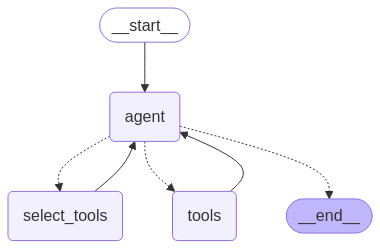

In [2]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

In [4]:
query = "Use available tools to calculate arc cosine of 0.5."

# Test it out
for step in agent.stream(
    {"messages": query},
    stream_mode="updates",
):
    for _, update in step.items():
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_tools (577cd5c8-023d-4a0e-b0a6-68aecc3f540c)
 Call ID: 577cd5c8-023d-4a0e-b0a6-68aecc3f540c
  Args:
    query: arc cosine calculator
================================= Tool Message =================================

Available tools: ['acos', 'asin']
================================== Ai Message ==================================
Tool Calls:
  acos (89467a08-4d6a-4cf0-891d-42048c7dc6f8)
 Call ID: 89467a08-4d6a-4cf0-891d-42048c7dc6f8
  Args:
    x: 0.5
================================= Tool Message =================================
Name: acos

1.0471975511965976
================================== Ai Message ==================================

The arc cosine of 0.5 is approximately 1.047 radians, which is equivalent to 60 degrees.


👆 LangSmith Trace: https://smith.langchain.com/public/75b82ea4-974b-45c1-8f6e-c00d4c1a750f/r

### Customizing tool retrieval

`langgraph-bigtool` equips an agent with a tool that is used to retrieve tools in the registry. You can customize the retrieval by passing `retrieve_tools_function` and / or `retrieve_tools_coroutine` into `create_agent`. These functions are expected to return a list of IDs as output.

In [ ]:
from langgraph.prebuilt import InjectedStore
from langgraph.store.base import BaseStore
from typing_extensions import Annotated


def retrieve_tools(
    query: str,
    # Add custom arguments here...
    *,
    store: Annotated[BaseStore, InjectedStore],
) -> list[str]:
    """Retrieve a tool to use, given a search query."""
    results = store.search(("tools",), query=query, limit=2)
    tool_ids = [result.key for result in results]
    # Insert your custom logic here...
    return tool_ids

builder = create_agent(
    llm, tool_registry, retrieve_tools_function=retrieve_tools
)
agent = builder.compile(store=store)

#### Retrieving tools without LangGraph Store

You can implement arbitrary logic for the tool retrieval, which does not have to run semantic search against a query. Below, we return collections of tools corresponding to categories:

In [ ]:
tool_registry = {
    "id_1": get_balance,
    "id_2": get_history,
    "id_3": create_ticket,
}

def retrieve_tools(
    category: Literal["billing", "service"],
) -> list[str]:
    """Get tools for a category."""
    if category == "billing":
        return ["id_1", "id_2"]
    else:
        return ["id_3"]

## Related work

- [Toolshed: Scale Tool-Equipped Agents with Advanced RAG-Tool Fusion and Tool Knowledge Bases](https://doi.org/10.48550/arXiv.2410.14594) - Lumer, E., Subbiah, V.K., Burke, J.A., Basavaraju, P.H. & Huber, A. (2024). arXiv:2410.14594.

- [Graph RAG-Tool Fusion](https://doi.org/10.48550/arXiv.2502.07223) - Lumer, E., Basavaraju, P.H., Mason, M., Burke, J.A. & Subbiah, V.K. (2025). arXiv:2502.07223.

- https://github.com/quchangle1/LLM-Tool-Survey

- [Retrieval Models Aren't Tool-Savvy: Benchmarking Tool Retrieval for Large Language Models](https://doi.org/10.48550/arXiv.2503.01763) - Shi, Z., Wang, Y., Yan, L., Ren, P., Wang, S., Yin, D. & Ren, Z. arXiv:2503.01763.